# Bayesian Tennis Simulation
### Experiment with bimodal prior (mixture of Gaussians) and uncertainty-manipulation (3 levels of ball speeds)

 Last change: January 25, 2025 by Stephan

----

Goal of this notebook: Simulating subjects' responses in the tennis experiment based on Prior and Likelihood

---
Steps in Bayesian modelling (see http://www.cns.nyu.edu/malab/bayesianbook.html)

Step 1 - Specifying the generative model
- Stimulus distribution p(s) - given by experimental protocol
- Measurement distribution p(x|s) - distribution of measurements (x) given stimulus (s) at any given trial

Step 2 - Describing how the observer performs inference (i.e., inverting the generative model)
- Compute posterior distribution for every trial - based on prior and likelihood function according to Bayes' rule

Step 3 - Response distribution

Procedure based on Neuromatch Tutorial https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/NMA2020/tutorials/W2D1_BayesianStatistics/student/W2D1_Tutorial3.ipynb#scrollTo=0x7qZ_Pum_B-



### Outputs of this notebook:  
- df "predicted responses": subjects' predicted response at every trial in the experiment based on Bayesian prior-likelihood integration
- Plot Estimation Error vs. Ball Position (true stimulus) as a function of uncertainty-condition (slow/moderate/fast)

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ipywidgets as widgets

Helper functions (from tutorial)

In [2]:
# Define my gaussian function
def gaussian(x_points, mu, sigma):
    """
    Returns a Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`

    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the gaussian

    Returns:
      Gaussian evaluated at `x`
    """
    p = np.exp(-(x_points-mu)**2/(2*sigma**2))
    return p / sum(p)

# Define myfunc function
def moments_myfunc(x_points, function):
  """
  Returns the mean, median and mode of an arbitrary function

  Args :
    x_points (numpy array of floats) - x-axis values
    function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

  Returns:
    (tuple of 3 scalars): mean, median, mode
  """

  # Calc mode of arbitrary function
  mode = x_points[np.argmax(function)]

  # Calc mean of arbitrary function
  mean = np.sum(x_points * function)

  # Calc median of arbitrary function
  cdf_function = np.zeros_like(x_points)
  accumulator = 0
  for i in np.arange(x_points.shape[0]):
    accumulator = accumulator + function[i]
    cdf_function[i] = accumulator
  idx = np.argmin(np.abs(cdf_function - 0.5))
  median = x_points[idx]

  return mean, median, mode

def plot_myarray(array, xlabel, ylabel, title):
  """ Plot an array with labels.

  Args :
    array (numpy array of floats)
    xlabel (string) - label of x-axis
    ylabel (string) - label of y-axis
    title  (string) - title of plot

  Returns:
    None
  """
  fig = plt.figure()
  ax = fig.add_subplot(111)
  colormap = ax.imshow(array, extent=[40, 100, 100, 40])
  cbar = plt.colorbar(colormap, ax=ax)
  cbar.set_label('probability')
  ax.invert_yaxis()
  ax.set_xlabel(xlabel)
  ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.set_aspect('auto')
  return None


# Define compute posterior Function
def compute_posterior_pointwise(prior, likelihood):
  "multiply the prior and likelihood"
  posterior = prior * likelihood
  "normalize the posterior"
  posterior /= posterior.sum()

  return posterior

# Define bimodal prior Function
def bimodal_prior(x, mu_1_prior= 40, sigma_1_prior= 5, mu_2_prior= 80, sigma_2_prior=5):

  prior = gaussian(x, mu_1_prior, sigma_1_prior) + gaussian(x, mu_2_prior, sigma_2_prior)
  prior /= prior.sum()

  return prior

def posterior_plot(x, prior=None, likelihood=None, posterior_pointwise=None, ax=None):
    """
    Plots normalized Gaussian distributions and posterior

    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        prior (numpy array of floats):  normalized probabilities for prior likelihood evaluated at each `x`
        likelihood(numpy array of floats):    normalized probabilities for likelihoodlikelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        ax: Axis in which to plot. If None, create new axis.

    Returns:
        Nothing.
    """
    if likelihood is None:
        likelihood = np.zeros_like(x)

    if prior is None:
        prior = np.zeros_like(x)

    if posterior_pointwise is None:
        posterior_pointwise = np.zeros_like(x)

    if ax is None:
      fig, ax = plt.subplots()

    ax.plot(x, prior, '-C2', label='Prior')
    ax.plot(x, likelihood, '-C1', label='Likelihood')
    ax.plot(x, posterior_pointwise, '-C0', label='Posterior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Ball locations (m)')

    return ax

## Simulate a single trial of tennis return based on bimodal prior and likelihood
This is just to get a feeling: see how changing the prior and likelihood influences the posterior

(55.00000000000021, 55.0068782510295)

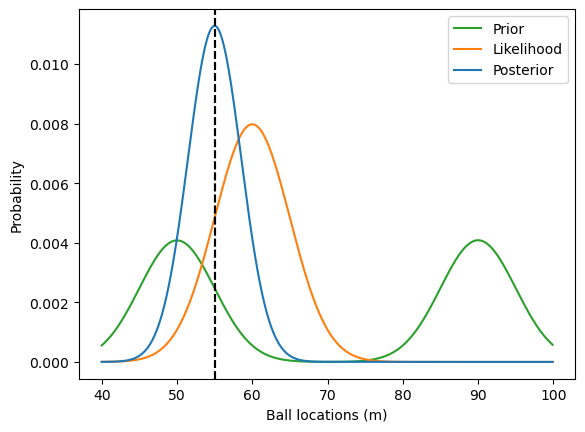

In [4]:
def bimodal_tennis_return(mu_1_prior, sigma_1_prior, mu_2_prior, sigma_2_prior, mu_likelihood, sigma_likelihood):

  # ball_positions = "true stimulus"
  x = np.arange(40, 100, 0.1)

  prior = bimodal_prior(x, mu_1_prior, sigma_1_prior, mu_2_prior, sigma_2_prior)
  likelihood = gaussian(x, mu_likelihood, sigma_likelihood)
  posterior = compute_posterior_pointwise(prior, likelihood)

  return x, prior, likelihood, posterior

# set prior
mu_1_prior= 50
sigma_1_prior= 5
mu_2_prior= 90
sigma_2_prior=5
# set likelihood
mu_likelihood = 60
sigma_likelihood = 5

# compute posterior
x, prior, likelihood, posterior_pointwise = bimodal_tennis_return(mu_1_prior, sigma_1_prior, mu_2_prior, sigma_2_prior, mu_likelihood, sigma_likelihood)
posterior_plot(x, prior, likelihood, posterior_pointwise)

# Read out mode and mean of the posterior
mode_posterior = x[np.argmax(posterior_pointwise)]
mean_posterior = np.sum(x*posterior_pointwise)

# plot a vertical line at the mode and mean
plt.axvline(mode_posterior, color='black', linestyle='--', label='Mode')
plt.axvline(mean_posterior, color='black', linestyle='--', label='Mean')

mode_posterior, mean_posterior

----

# Simulate tennis experiment


Overview
- Prior fixed at mu_1 = 50, sigma_1 = 5, and mu_2 = 90, sigma_1 = 5

- Loops through x_true (actual ball positions) in experimental protocol

- Sigma of likelihood depends on uncertainty condition. Default: slow = 2, medium = slow *2, fast = slow *5

- Likelihood array -> Likelihood for every possible "encoding"/"measurement" of x
- Posterior array -> Posterior for every possible "encoding"/"measurement" of x

- Mariginalized to obtain the response distribution

- Difference between estimated_response and true simulus -> "estimation errror"; needs to be computed for each trial and added in a new column

## Import experimental protocol

- relevant columns = trial_id, condition (slow/moderate/fast), ball_positions (="true_stimulus")
- 480 trials in total: 160 for each uncertainty condition (slow/moderate/fast)
- same distribution of ball_positions for every uncertainty condition


In [5]:
# Import excel file vr_tennis_exp_fs24_protocol_day3
experimental_protocol = pd.read_excel('../experimental_protocols/vr_tennis_exp_fs24_protocol_day3.xlsx')

### Before starting the tennis simulation, the relvant functions are created and illustrated with plots

## (1) Function to generate likelihood array

- Creates likelhoods for all potential "encodings/observations/measurements" of x_true (ball position) at a given trial
- Each likelihood will have a different mean; likelihood array made up of 1,000 row-Gaussians

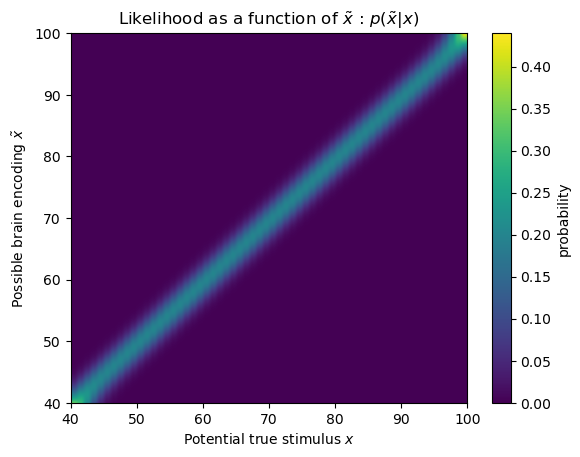

In [6]:
x = np.arange(40, 100, 1)
hypothetical_stim = np.linspace(40, 100, 1000)

def compute_likelihood_array(x_points, stim_array, sigma=2):

    # initializing likelihood_array
    likelihood_array = np.zeros((len(stim_array), len(x_points)))

    # looping over stimulus array
    for i in range(len(stim_array)):
        likelihood_array[i, :] = gaussian(x_points, stim_array[i], sigma)

    return likelihood_array

likelihood_array = compute_likelihood_array(x, hypothetical_stim)

plot_myarray(likelihood_array,
              'Potential true stimulus $x$',
              'Possible brain encoding $\~x$',
              'Likelihood as a function of $\~x$ : $p(\~x | x)$')

## (2) Function to generate bimodal prior array (again plotted as function of "all potential encodings of x")

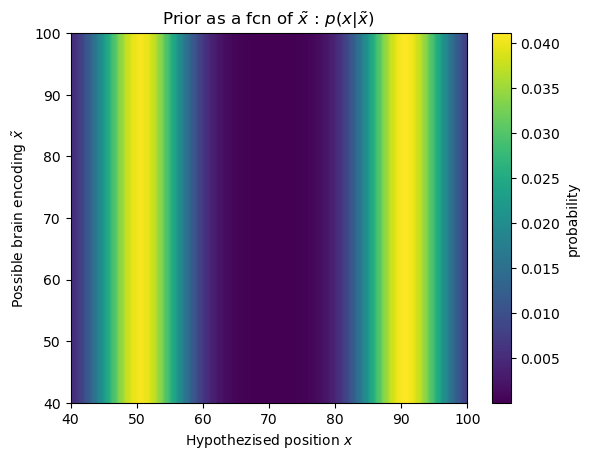

In [7]:
x = np.arange(40, 100, 1)

def calculate_bimodal_prior_array(x_points, stim_array, mu_1_prior= 50, sigma_1_prior= 5, mu_2_prior= 90, sigma_2_prior=5):

    prior_mixed = gaussian(x_points, mu_1_prior, sigma_1_prior) + gaussian(x, mu_2_prior, sigma_2_prior)
    prior_mixed /= prior_mixed.sum() # normalize

    prior_array = np.tile(prior_mixed, len(stim_array)).reshape(len(stim_array), -1)
    return prior_array

prior_array = calculate_bimodal_prior_array(x, hypothetical_stim)


plot_myarray(prior_array,
               'Hypothezised position $x$', 'Possible brain encoding $\~x$',
               'Prior as a fcn of $\~x$ : $p(x|\~x)$')

##  (3) Function to calculate posterior (again as a function of "all potential encodings of x")

- Takes likelihood and a prior for each brain encoded position  $\~x$ (part 1 and 2), and multiplies them row-wise
- That is, each row of the posterior array will be the posterior resulting from the multiplication of the prior and likelihood of the same equivalent row.

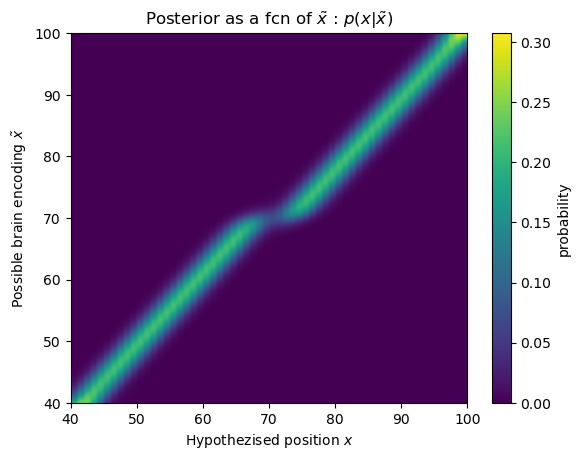

In [8]:
def calculate_posterior_array(prior_array, likelihood_array):

    posterior_array = prior_array * likelihood_array
    posterior_array /= posterior_array.sum(axis=1, keepdims=True)  # normalize each row separately

    return posterior_array

posterior_array = calculate_posterior_array(prior_array, likelihood_array)

plot_myarray(posterior_array,
               'Hypothezised position $x$',
               'Possible brain encoding $\~x$',
               'Posterior as a fcn of $\~x$ : $p(x | \~x)$')

## (4) Function to calculate the binary decision array

- We now have a posterior distribution (for each possible brain encoding/measurement  $\~x$)
### How to get an estimte of particpants' response?

- We make the assumptions that participants take the mean of the posterior (decision rule) as a response estimate for the location (=PME). That is, minimize MSE.
- We represent  $\^x$  as a function of the encoded stimulus  $\~x$ . This will result in a 2D binary decision array. 
- To do so, this function scans the posterior matrix (i.e. row-wise), and set the array cell value to 1 at the mean of the row-wise posterior.

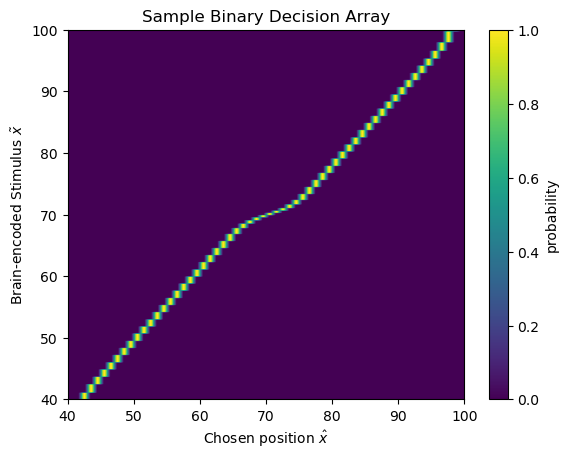

In [9]:
def calculate_binary_decision_array(x_points, posterior_array):

    binary_decision_array = np.zeros_like(posterior_array)

    for i in range(len(posterior_array)):
        # calculate mean of posterior using 'moments_myfunc'
        mean, _, _ = moments_myfunc(x_points, posterior_array[i])
        # find the postion of mean in x_points (closest position)
        idx = np.argmin(np.abs(x_points - mean))
        binary_decision_array[i, idx] = 1

    return binary_decision_array

binary_decision_array = calculate_binary_decision_array(x, posterior_array)

plot_myarray(binary_decision_array,
               'Chosen position $\hat x$', 'Brain-encoded Stimulus $\~ x$',
               'Sample Binary Decision Array')

## (5) Function to generate the input array

- Now we have the best estimate ($\^x$) given an encoded/measured sitimulus ($\~x$). 
- In this step, we need to know how probable each $\~x$ is given the true stimulus x


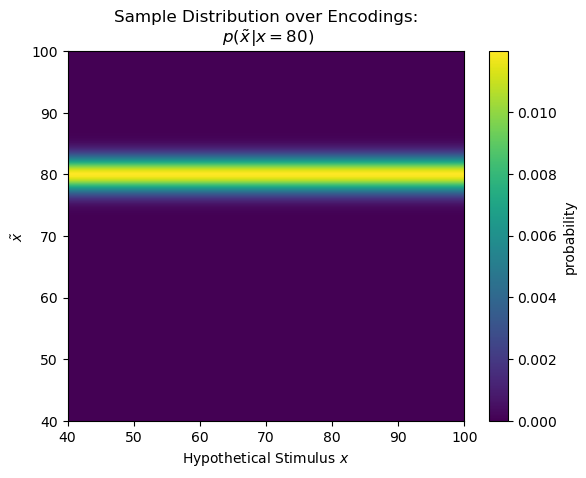

In [10]:
def generate_input_array(x_points, stim_array, posterior_array,
                         mean=80, sigma=2):

    input_array = np.zeros_like(posterior_array)

    for i in range(len(x_points)):
        input_array[:, i] = gaussian(stim_array, mean, sigma)

    return input_array

input_array = generate_input_array(x, hypothetical_stim, posterior_array)

plot_myarray(input_array,
               'Hypothetical Stimulus $x$', '$\~x$',
               'Sample Distribution over Encodings:\n $p(\~x | x = 80)$')

## (6) Function for marginalization

- Based on a true stimulus (x_true)  and a way to link it to potential encodings/measurements, we can calculate the distribution of encodings and ultimately estimates.
- To integrate over all possible hypothetical values of  ($\~x$)  we marginalize; that is, we first compute the dot-product from the true presented stimulus and our binary decision array and then sum over x.

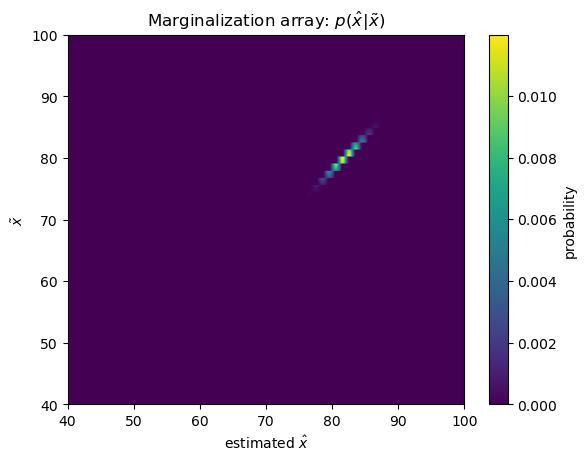

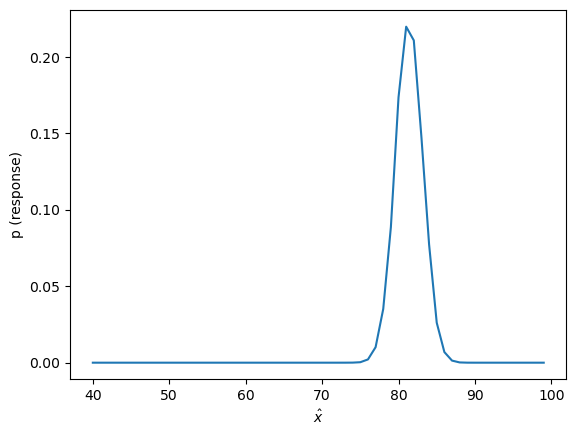

Mean of marginal: 81.37614240141282


In [11]:
def marginalization(input_array, binary_decision_array):

    marginalization_array = input_array * binary_decision_array
    marginal = np.sum(marginalization_array, axis=0)  # note axis
    marginal /= marginal.sum()  # normalize

    return marginalization_array, marginal

marginalization_array, marginal = marginalization(input_array, binary_decision_array)

plot_myarray(marginalization_array, 'estimated $\hat x$', '$\~x$', 'Marginalization array: $p(\^x | \~x)$')

plt.figure()
plt.plot(x, marginal)
plt.xlabel('$\^x$')
plt.ylabel('p (response)')
plt.show()

# mean of marginal
mean, _, _ = moments_myfunc(x, marginal)
print(f"Mean of marginal: {mean}")



# Simulate full tennis experiment

- Uses function 1 from above to generate the prior array
- Loops through all experimental trials (i.e., through all x_trues)
    - For every trial, uses functions 2-6 from above to
        - generate a likelihood array
        - calculate the posterior
        - marginalise to obtain a response estimate
- Saves the estimated responses for all trials

In [12]:
# define the prior
# use function (2) from above 
prior = calculate_bimodal_prior_array(x, hypothetical_stim)

# x_trues are the ball positions in the experiment (the true stimulus)
x_trues = experimental_protocol['ball_positions'].values
x_trues = np.array(x_trues)
  
# accumulate results here
estimated_response = []
  
# Loop through all trials of the experiment  
for i, x_true in enumerate(x_trues):
    
  sigma_likelihood = 2 # assumed SD of likelihood in condition "slow"

  if experimental_protocol.loc[i, 'condition'] == "slow":
    sigma_likelihood = sigma_likelihood
  elif experimental_protocol.loc[i, 'condition'] == "moderate":
    sigma_likelihood = sigma_likelihood * 2
  elif experimental_protocol.loc[i, 'condition'] == "fast":
    sigma_likelihood = sigma_likelihood * 5
  else:
    print("did not read the speed-condition-column")
   
  # generate likelihood array using function (1) from above   
  likelihood_array = compute_likelihood_array(x, hypothetical_stim, sigma_likelihood)
  # multiply the prior and likelihood to obtain the posterior array using function (3) from above
  posterior_array = calculate_posterior_array(prior, likelihood_array)
  # calculate the binary decision array using function (4) from above
  binary_decision_array = calculate_binary_decision_array(x, posterior_array)
  # generate the input array using function (5) from above
  input_array = generate_input_array(x, hypothetical_stim, posterior_array, mean=x_true, sigma=2)
  # marginalize using function (6) from above
  marginalization_array, marginal = marginalization(input_array, binary_decision_array)
  # get the mean of the response distribution as the estimated response
  mean, _, _ = moments_myfunc(x, marginal)
  estimated_response.append(mean)

## Calculate a predicted "estimation error" for every trial and save in df "Predicted Responses"
- diff between ball position and estimated response

In [13]:
predicted_responses = pd.DataFrame({'trial_id': experimental_protocol['trial_id'],
                                     'condition': experimental_protocol['condition'],
                                     'ball_positions': experimental_protocol['ball_positions'],
                                     'estimated_response': estimated_response})

# Calculate the estimation error: diff between ball position and estimated response
predicted_responses['estimation_error'] = predicted_responses['ball_positions'] - predicted_responses['estimated_response']

## Plot Bayesian predictions: Estimation Error vs. Ball positions as a function of the uncertainty condition (slow/moderate/fast)

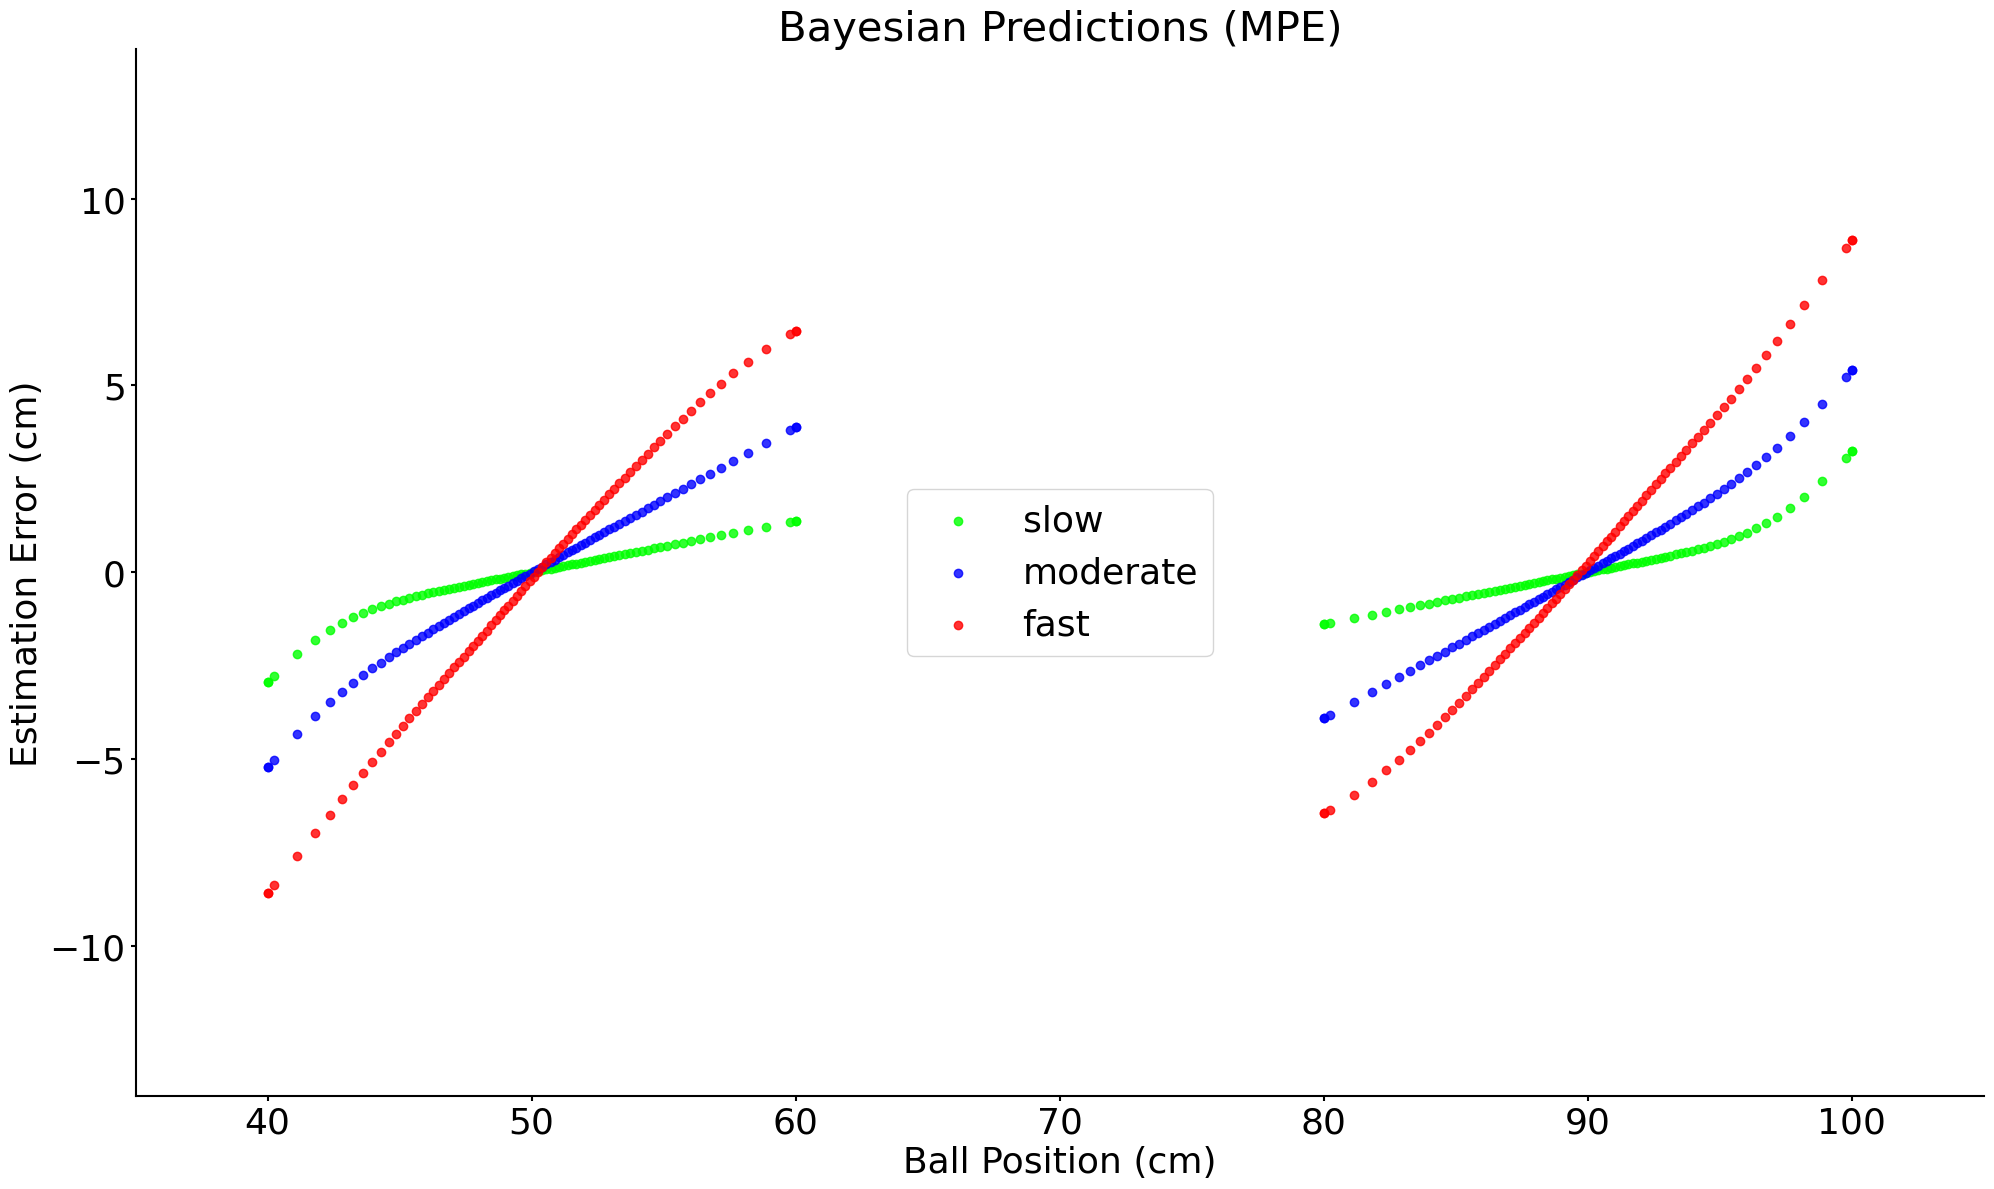

In [27]:
# Map conditions to colors
condition_colors = {
    'fast': 'red',
    'moderate': 'blue',
    'slow': '#00FF00'
}

# Create plot of the predicted responses
plot_3_uncertainty_levels = sns.lmplot(x='ball_positions', y='estimation_error', hue='condition', palette=condition_colors, data=predicted_responses, legend = False, fit_reg=False,
    height=12,  # Height in inches
    aspect=1.67)

# Limit y and x axis
plot_3_uncertainty_levels.set(ylim=(-14, 14))
plot_3_uncertainty_levels.set(xlim=(35, 105))

# Set axis labels
plot_3_uncertainty_levels.set_ylabels('Estimation Error (cm)', fontsize=26)
plot_3_uncertainty_levels.set_xlabels('Ball Position (cm)', fontsize=26)

# Aesthetics
# Font size of ticks
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Thickness of axes lines
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.tick_params(width=1.5)

# Add lend and title
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=26)
plt.title('Bayesian Predictions (MPE)', fontsize=30)
    

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.savefig('prediction_plot.png', dpi=300)
plt.savefig('prediction_plot.svg')